In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [3]:
orders = pd.read_csv('https://stepik.org/media/attachments/lesson/413464/RFM_ht_data.csv',dtype={'CustomerCode':'str'})

## Предподготовка данных

In [ ]:
orders.head()

In [ ]:
orders.shape

In [ ]:
orders.dtypes

In [4]:
orders['InvoiceDate'] = pd.to_datetime(orders['InvoiceDate'])

In [ ]:
orders.dtypes

## Какое максимальное количество покупок было совершено одним пользователем?

In [ ]:
orders.groupby('CustomerCode') \
    .agg({'InvoiceNo' : 'count'}) \
    .rename(columns={'InvoiceNo' : 'Purchases'}) \
    .max()

## RFM-анализ

In [ ]:
orders.CustomerCode.nunique()

In [5]:
last_date = orders.InvoiceDate.max()

In [6]:
rfmTable = orders.groupby('CustomerCode',as_index=False).agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                                            'InvoiceNo': 'count',      # Frequency #Количество заказов
                                            'Amount': 'sum'}) # Monetary Value #Общая сумма по всем заказам

In [7]:
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)

In [8]:
#Показатели R, F, M для каждого пользователя рассчитаны
rfmTable.head()

,CustomerCode,recency,frequency,monetary_value
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88


In [9]:
# Считаем 25-й, 50-й, и 75 перцентили
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])

In [ ]:
quantiles

In [10]:
rfmSegmentation = rfmTable

In [11]:
# Пишем функции для присвоения пользователям групп по показателям R и F
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [12]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)                             + rfmSegmentation.F_Quartile.map(str)                             + rfmSegmentation.M_Quartile.map(str)

In [ ]:
rfmSegmentation.head()

In [13]:
rfm_table = rfmSegmentation.pivot_table(
    
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)

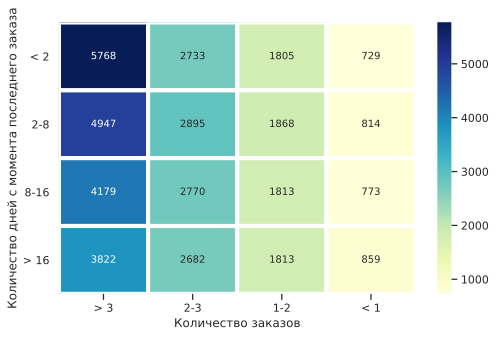

In [14]:
# figure
fig, ax = plt.subplots(figsize=(8, 5))
# plot heatmap
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4)
# xticks
ax.xaxis.tick_bottom()
xticks_labels = ['> 3', '2-3', '1-2', '< 1']
plt.xticks(np.arange(4) + .5, labels=xticks_labels)
#yticks
yticks_labels = ['< 2', '2-8', '8-16', '> 16']
plt.yticks(np.arange(4) + .5, labels=yticks_labels, rotation=0)
# axis labels
plt.xlabel('Количество заказов')
plt.ylabel('Количество дней с момента последнего заказа')

plt.show()

## Выведем список всех групп c количеством клиентов в них

In [16]:
rfmSegmentation.groupby('RFMClass') \
                .agg({'CustomerCode' : 'count'}) \
                .rename(columns={'CustomerCode' : 'Quantity'}) \
                .sort_values('Quantity', ascending=False)

,Quantity
RFMClass,
444,10624
111,9705
443,6729
344,6593
211,5847
...,...
424,63
214,60
114,60
